#  **A/B TESTING**

### **Analyze the results of an A/B test run by an E-commerce website**
- Data Source - Kaggle 

#### **PART 1 : PROBABILITY**

In [1]:
# import libraries
import matplotlib
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(42)


In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

In [4]:
df.user_id.nunique()

290584

In [5]:
# The proportion of users converted
(df.converted==1).mean()

np.float64(0.11965919355605512)

In [6]:
# The number of times new_page and treatment don't line up
((df.group=='treatment') & (df.landing_page =='old_page')).sum() + ((df.group == 'control') & (df.landing_page == "new_page")).sum()

np.int64(3893)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


 No missing values in the dataset

- For the rows where treatment is not aligned with the new page and control not aligned with old page , we cannot be sure whether old page or the new page was received . Those rows need to be dropped.

In [8]:
df['misaligned'] = ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'control') & (df['landing_page'] == 'new_page'))

In [10]:
df2 = df.query('misaligned == False')

In [11]:
df2.shape

(290585, 6)

In [12]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
df2['user_id'].nunique()

290584

In [14]:
df2['user_id'].value_counts().sort_values(ascending=False).head()

user_id
773192    2
834487    1
936923    1
679687    1
719014    1
Name: count, dtype: int64

In [15]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,False


In [17]:
df2.drop(1899,axis = 0, inplace = True)

/var/folders/r7/w1kz2nvd0bsc6fbv8pgkkb7c0000gn/T/ipykernel_18152/2911819018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(1899,axis = 0, inplace = True)


In [18]:
df2.shape

(290584, 6)

In [19]:
# probability of an individual converting regardless the page they receive

(df2['converted']==1).mean()

np.float64(0.11959708724499628)

In [21]:
# If an individual was in the control group, what is the probability that they convered

actual_pold = (df2.query('group == "control"')['converted']==1).mean()
actual_pold

np.float64(0.1203863045004612)

In [36]:
# If an individual was in the treatment group, what is the probability that they converted  
actual_pnew = (df2.query('group == "treatment"')['converted']==1).mean()
actual_pnew

np.float64(0.11880806551510564)

In [23]:
# Probability that an individual received the new page

(df2['landing_page'] == 'new_page').mean()

np.float64(0.5000619442226688)

- The difference between converted rate of control and treatment group is very less. So this does not convince that one page leads to more conversions than the other. More statistics are needed.

#### **PART 2 : A/B TEST**

Hypothesis:
- Null : pold - pnew >= 0**
- Alernative : pold - pnew < 0

In [24]:
# Convert rate for pnew under null

pnew_null = (df2['converted']==1).mean()
pnew_null

np.float64(0.11959708724499628)

In [25]:
# Convert rate of pold under null
pold_null = (df2['converted']==1).mean()
pold_null

np.float64(0.11959708724499628)

In [26]:
p_null = pnew_null

In [28]:
n_new = (df2['landing_page'] == 'new_page').sum()
n_new

np.int64(145310)

In [29]:
n_old = (df2['landing_page'] == 'old_page').sum()
n_old

np.int64(145274)

In [30]:
# Simulate  nnew transactions with a convert rate of  pnew under the null. 
# Store these  nnew 1's and 0's in new_page_converted.

new_page_converted = np.random.binomial(n_new, p_null)

In [31]:
#Simulate  nold transactions with a convert rate of  pold under the null. 
# Store these  nold 1's and 0's in old_page_converted.

old_page_converted = np.random.binomial(n_old, p_null)

In [32]:
# Find  pnew -  pold from your simulated values

diff=new_page_converted/n_new-old_page_converted/n_old
diff

np.float64(0.001993912870163858)

In [33]:
# Simulate 10,000  pnew -  pold values using this same process 
p_diffs=[]
p_diffs = np.random.binomial(n_new, p_null, 10000)/n_new - np.random.binomial(n_old, p_null, 10000)/n_old   

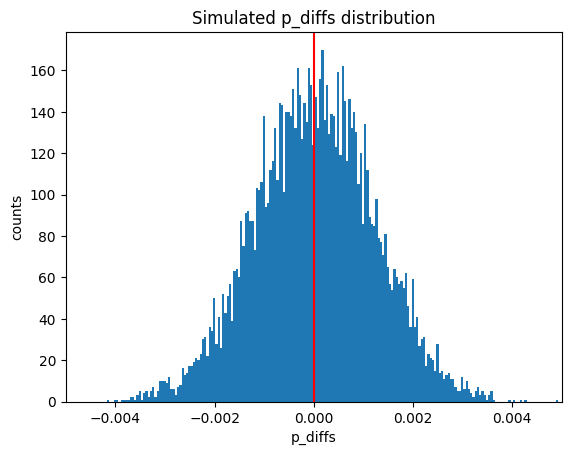

In [34]:
# Plot a histogram of the p_diffs   

plt.hist(p_diffs,bins = 200)
plt.xlim(-0.005,0.005)
plt.xlabel('p_diffs')
plt.ylabel('counts')
plt.title('Simulated p_diffs distribution')
plt.axvline(0.000, color='red')



In [37]:
# What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv
actual_diff = actual_pnew - actual_pold
actual_diff,actual_pnew, actual_pold

(np.float64(-0.0015782389853555567),
 np.float64(0.11880806551510564),
 np.float64(0.1203863045004612))

In [38]:
actual_diff=actual_pnew-actual_pold
(p_diffs>actual_diff).mean()


np.float64(0.9108)

- This is the p value. The value 0.91 is much larger than alpha 0.05. 
- Therefore we cannot reject null and new page is not better at leading to conversion than old page.

# BUILT IN MODEL 

In [39]:
import statsmodels.api as sm
convert_old = (df2.query('landing_page == "old_page"')['converted']==1).sum()
convert_new = (df2.query('landing_page == "new_page"')['converted']==1).sum()
n_old =  (df2['landing_page'] == 'old_page').sum()
n_new =  (df2['landing_page'] == 'new_page').sum()

convert_old, convert_new, n_old, n_new

(np.int64(17489), np.int64(17264), np.int64(145274), np.int64(145310))

In [40]:
# Compute ztest and p-value using statsmodels

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(np.float64(-1.3109241984234394), np.float64(0.9050583127590245))

In [ ]:
from scipy.stats import norm 
# Tells us how significant the z-score is
print(norm.cdf(z_score))
print(norm.ppf(1-(0.05)))

0.09494168724097551
1.644853626951472


- The z-core is 1.31 which is way lower than the critical value 1.64
- P value is 0.9 very larger than alpha value than 0.05
- Therefore based on this statistics we cannot reject null

#### **PART 3: A REGRESSION APPROACH**

In [52]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'].astype(int)
df2.head()

/var/folders/r7/w1kz2nvd0bsc6fbv8pgkkb7c0000gn/T/ipykernel_18152/1995883593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
/var/folders/r7/w1kz2nvd0bsc6fbv8pgkkb7c0000gn/T/ipykernel_18152/1995883593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'].astype(int)


,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0


In [53]:
lm=sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Jan 2026   Pseudo R-squ.:               8.077e-06
Time:                        19:58:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

- The intercept - 1.988 . exp(-1.988) is 0.1366. This means the conversion rate of baseline cases is 0.1366
- The coefficient for ab_page(treatment) is -0.0150. exp(-0.015) = 0.985 and 1/0.985 is 1.015. This means that the baseline (control that uses old_page) is 1.015 times likely to result in a conversion relative to treatment.
- The p value is 0.19. This is also larger as compared to 0.05 alpha value.
- Therefore statistically we fail to reject the null hypothesis. The conversion rate does not depend on the landing_page.

#### This is different from results in Part II because the null hypothesis is different. In Part II, null=new page is not better than old page, alternative=new page is better. So Part II is a one-sided test. Here, we hope to find out that conversion depends on which landing page users use. The alternative here is that conversion rates are different, and null is there is no difference. So this is a two-sided test

# Now let us check whether the conversion rate depend on the country

In [54]:
country = pd.read_csv("countries.csv")
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [55]:
# merge df2 with countries

df2 = df2.merge(country, on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US


In [58]:
#create dummmy columns for country
df2[['CA','UK','US']]= pd.get_dummies(df2['country']).astype(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US,0,0,1


In [59]:
# run logistic regression on countries
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 24 Jan 2026   Pseudo R-squ.:               2.323e-05
Time:                        20:35:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

- Here the baseline is US. 
- The coef for CA is -0.0408. exp(0.0408)= 1/0.953 = 1.049
- This means that users in US is 1.049 times likely to convert relative to users in CA.
- The coef for UK is 0.0099.exp(0.0099) = 1.01
- This means that users in UK is 1.01 times likely to covert relative to users in US.
- The variables ab_page and country are independent of each other

#### **PART 4 : How does day of week affect conversion rate**

In [61]:
df2['datetime'] = pd.to_datetime(df2['timestamp'],errors='coerce')

In [63]:
df2['dow'] = df2['datetime'].dt.dayofweek

In [67]:
df2['dow'] = df2['datetime'].dt.dayofweek
# Create dummy columns with day names
dow_dummies = pd.get_dummies(df2['dow'], prefix='dow').astype(int)
df2 = pd.concat([df2, dow_dummies], axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page,country,CA,...,4,5,6,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,...,False,True,False,0,0,0,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US,0,...,False,False,False,0,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US,0,...,False,False,False,0,0,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US,0,...,False,False,True,0,0,0,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US,0,...,False,True,False,0,0,0,0,0,1,0


In [65]:
df2.head()

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page,country,CA,...,US,datetime,dow,0,1,2,3,4,5,6
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,...,1,2017-01-21 22:11:48.556739,5,False,False,False,False,False,True,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US,0,...,1,2017-01-12 08:01:45.159739,3,False,False,False,True,False,False,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US,0,...,1,2017-01-11 16:55:06.154213,2,False,False,True,False,False,False,False
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US,0,...,1,2017-01-08 18:28:03.143765,6,False,False,False,False,False,False,True
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US,0,...,1,2017-01-21 01:52:26.210827,5,False,False,False,False,False,True,False


In [68]:
# perform logistic regression to see if there is significant difference of conversion rates in different day of week
# Use dow_1, dow_2, etc. (dow_0 is the baseline - Monday)
lm=sm.Logit(df2['converted'], df2[['intercept','ab_page','dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            7
Date:                Sat, 24 Jan 2026   Pseudo R-squ.:               3.402e-05
Time:                        21:01:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4044
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9742      0.015   -127.751      0.000      -2.004      -1.944
ab_page       -0.0149      0.011     -1.306      0.192      -0.037       0.007
dow_1         -0.0152      0.020     -0.754      0.451      -0.055       0.024
dow_2         -0.0077      0.021     -0.363      0.716      -0.049       0.034
dow_3         -0.0112      0.021     -0.528      0.598      -0.053       0.030
dow_4         -0.0425      0.021     -2.000      0.045      -0.084      -0.001
dow_5         -0.0031      0.021     -0.147      0.883      -0.044       0.038
dow_6         -0.0254      0.021     -1.200      0.230      -0.067       0.016
==============================================================================
"""

- Although the conversion rates in different days of week are more or less different, the difference and p values are not significant enough for me to conclude whether a specific week day had more conversion rate. Therefore I will pick out 2 different days, on which the conversion rates are biggest or smallest, and test if their difference is significant.¶

In [69]:
# calculate mean conversion rates on each day of week
dow_columns=pd.get_dummies(df2['dow'])
dow_rate=pd.DataFrame([(lambda x:(df2[x] * df2.converted).sum()/df2[x].sum()) (x) for x in dow_columns], index=list(pd.get_dummies(df2['dow']).columns), columns=['conversion_rate'])
dow_rate


,conversion_rate
0,0.121151
1,0.119538
2,0.120334
3,0.119961
4,0.116691
5,0.120822
6,0.118477


- The biggest difference in conversion rates is between Friday and Monday. I will create a sub-dataframe that includes only these two days.

In [70]:
# create a sub-dataframe that only included Friday and Monday data
sub_df2=df2.query('dow=="Friday" | dow=="Monday"' )


In [72]:
# create a sub-dataframe that only included Friday and Monday data
# dow: 0=Monday, 4=Friday
sub_df2 = df2.query('dow==0 | dow==4')

# Create a Monday indicator (Friday is baseline when Monday=0)
sub_df2['Monday'] = (sub_df2['dow'] == 0).astype(int)

# run a logistic regression
lm = sm.Logit(sub_df2['converted'], sub_df2[['intercept', 'ab_page', 'Monday']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.365050
         Iterations 6


/var/folders/r7/w1kz2nvd0bsc6fbv8pgkkb7c0000gn/T/ipykernel_18152/2986754889.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df2['Monday'] = (sub_df2['dow'] == 0).astype(int)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                85065
Model:                          Logit   Df Residuals:                    85062
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 Jan 2026   Pseudo R-squ.:               6.775e-05
Time:                        21:08:28   Log-Likelihood:                -31053.
converged:                       True   LL-Null:                       -31055.
Covariance Type:            nonrobust   LLR p-value:                    0.1220
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0195      0.019   -106.811      0.000      -2.057      -1.982
ab_page       -0.0092      0.021     -0.436      0.663      -0.051       0.032
Monday         0.0425      0.021      2.001      0.045       0.001       0.084
==============================================================================
"""

- On Mondays, users are 1.04 times likely to be converted relative to users in Friday. If type I error is set at 0.05, given the p value here is 0.045, the regression result indicate a significant difference in conversion rate between Monday and Friday.

#### PART 5 : SHOULD WE RUN THE TEST LONGER TIME

- (1) first calculate the mean conversion rates at each different day as time went on.
- (2) create visual for mean conversion rates vs. days
- (3) run a linear regression of the conversion rates on days

In [73]:
# check when did the test start and end
df2['datetime'].min(), df2['datetime'].max()

(Timestamp('2017-01-02 13:42:05.378582'),
 Timestamp('2017-01-24 13:41:54.460509'))

The test started on 2nd Jan 2017 and ended on 24th Jan 2017.


In [74]:
# To get mean conversion rates of each day let us group the rows by the day.

df2['day'] = df2['datetime'].dt.date

In [75]:
# create a dataframe that aggregates mean conversion rate of old and new pages of individual day
df2_by_day = pd.DataFrame()
old_df = df2.query('landing_page == "old_page"')
new_df = df2.query('landing_page == "new_page"')
df2_by_day['old_rate'] = old_df.groupby('day')['converted'].mean()
df2_by_day['new_rate'] = new_df.groupby('day')['converted'].mean()
df2_by_day.reset_index(inplace = True)

view trends of p_old and p_new vs. day, to see if there is a visible correlation

Text(0.5, 1.0, 'Conversion rates at different days of the month')

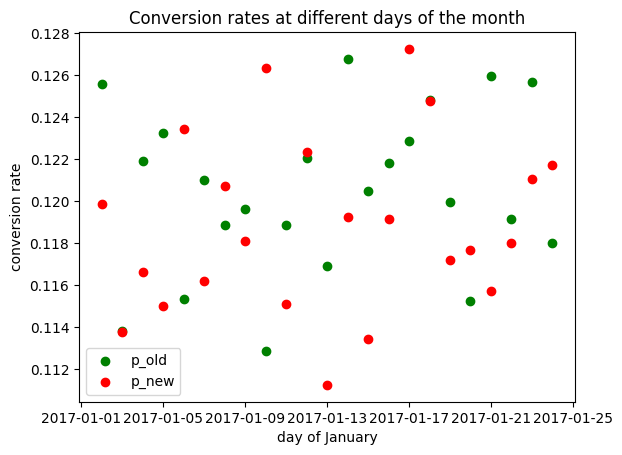

In [76]:
# create a scatter plot to see if there is increase in conversion rate as  time goes on
plt.scatter(df2_by_day['day'],df2_by_day['old_rate'],color = 'green',label = 'p_old')
plt.scatter(df2_by_day['day'],df2_by_day['new_rate'],color = 'red',label ='p_new')
plt.xlabel('day of January')
plt.ylabel('conversion rate')
plt.legend()
plt.title('Conversion rates at different days of the month')



Text(0.5, 1.0, 'p_new - p_old')

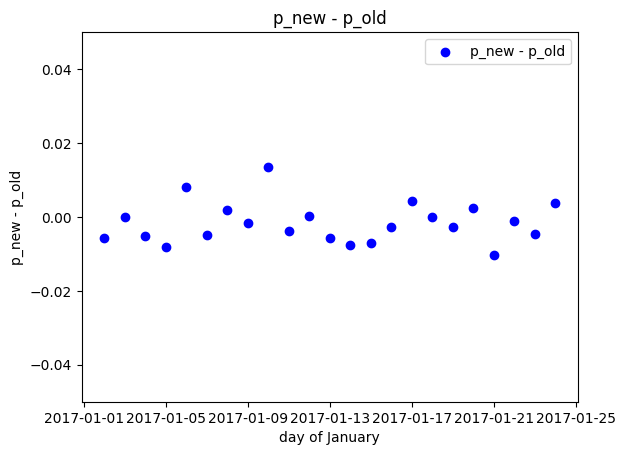

In [78]:
# create a scatter plot to see if there is increase in conversion rate as time goes on
plt.scatter(df2_by_day['day'],  df2_by_day['new_rate']-df2_by_day['old_rate'], color='blue',label='p_new - p_old')
plt.xlabel('day of January')
plt.ylabel('p_new - p_old')
plt.ylim(-0.05, 0.05)
plt.legend()
plt.title('p_new - p_old')


run linear regression on p_old and day to see if these is statistically significant change in conversion rates


In [81]:
df2_by_day['intercept'] = 1
# Convert date to ordinal (numeric representation)
df2_by_day['day_ordinal'] = pd.to_datetime(df2_by_day['day']).map(lambda x: x.toordinal())

lm = sm.OLS(df2_by_day['old_rate'], df2_by_day[['intercept', 'day_ordinal']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               old_rate   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6566
Date:                Wed, 28 Jan 2026   Prob (F-statistic):              0.427
Time:                        18:37:56   Log-Likelihood:                 95.500
No. Observations:                  23   AIC:                            -187.0
Df Residuals:                      21   BIC:                            -184.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     -74.5926     92.201     -0.809      0.428    -266.336     117.151
day_ordinal     0.0001      0.000      0.810      0.427      -0.000       0.000
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   2.626
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                0.911
Skew:                          -0.150   Prob(JB):                        0.634
Kurtosis:                       2.073   Cond. No.                     8.17e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.17e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- coef=0.0001, p value=0.427, R-square=0.030. All these indicate that there is no statistically significant correlation between p_old and day. Therefore the conversion rate of old page is not changing with running time

run linear regression on p_new and day to see if these is statistically significant change in conversion rate


In [83]:
lm = sm.OLS(df2_by_day['new_rate'], df2_by_day[['intercept', 'day_ordinal']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               new_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.6226
Date:                Wed, 28 Jan 2026   Prob (F-statistic):              0.439
Time:                        18:40:35   Log-Likelihood:                 94.255
No. Observations:                  23   AIC:                            -184.5
Df Residuals:                      21   BIC:                            -182.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     -76.6754     97.329     -0.788      0.440    -279.081     125.731
day_ordinal     0.0001      0.000      0.789      0.439      -0.000       0.000
==============================================================================
Omnibus:                        0.655   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.695
Skew:                           0.333   Prob(JB):                        0.706
Kurtosis:                       2.470   Cond. No.                     8.17e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.17e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- coef=0.0001, p value=0.439, R-square=0.029. All these indicate that there is no statistically significant correlation between p_new and day. Therefore the conversion rate of new page is not changing with running time

run a linear regression to check if p_new-p_old changes over time

In [84]:
lm=sm.OLS(df2_by_day['new_rate']-df2_by_day['old_rate'], df2_by_day[['intercept', 'day_ordinal']])
results=lm.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                 0.0002499
Date:                Wed, 28 Jan 2026   Prob (F-statistic):              0.988
Time:                        18:42:08   Log-Likelihood:                 87.310
No. Observations:                  23   AIC:                            -170.6
Df Residuals:                      21   BIC:                            -168.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0828    131.640     -0.016      0.988    -275.843     271.678
day_ordinal  2.826e-06      0.000      0.016      0.988      -0.000       0.000
==============================================================================
Omnibus:                        5.420   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                3.444
Skew:                           0.885   Prob(JB):                        0.179
Kurtosis:                       3.680   Cond. No.                     8.17e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.17e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- R-square =0, coef is 0, p value is close to 1. There is definitely not a statistically significant correlation between p_new-p_old and day.

# CONCLUSIONS :

We analyzed user conversion rate vs. their landing_pages. Both A/B testing and logistic regression were employed to answer the same question.

- In A/B testing, we performed one-sided hypothesis testing : whether new page leads to more conversion rate or is it better than the old page.The null is that the new page is not better than old page. The alternative is that the new page is better. The resulted p_value from the test is 0.9, therefore we cannot reject the null and conclude that **new page is not better than the old page in leading to conversion.**

- In Logistic regression method, I intend to prove that conversion rates are dependent on the landing page, therefore it is a two-sided hypothesis test. The null is that there is no difference between conversion rate of old page and new page. The alternative is that there is a difference. The resulted p_value from the test is almost 0.2, therefore we cannot reject the null and conclude that **there is no statistically significant difference between the conversion rates of the landing pages.**

- Besides landing page, I also tested whether country matters in the conversion rates. There were not any statistically significant proofs and thus we conclude that **country does not influence the conversion rates.**

- I also tried to find out whether the day of week matters. When considering all the days of the week , I **didnt find any statistically significant evidence to support hat specific day of the week has better conversion rates**. But comparing Monaday and Friday , I did find that the **conversion rate on Monday was more stastistically better than that on Friday.**

- Then I tried to find out whether running the test longer time improves conversion rates. Neither old_page nor new_page conversion rate improved with time. From the linear regression of pnew_p_old against day, the R_square = 0 and p_value s close to 1. Therefore there is not any indication that **running the test longer will improve test results, and I do not suggest running longer time.**
